In [1]:
#importing required libraries
%matplotlib inline
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#importind data as pandas dataframe
amazon_data = pd.read_csv("Reviews.csv")

In [2]:
#getting the number of data points and number of columns of the data
print("number of rows in data=",amazon_data.shape[0])
print("number of columns in data=",amazon_data.shape[1])
print("\n")
amazon_data.head(5)

number of rows in data= 568454
number of columns in data= 10




,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#changing the timestamp column into standard time
amazon_data["Time"] = pd.to_datetime(amazon_data["Time"] , unit ="s")

In [4]:
#getting the information about columns
print(amazon_data.columns)
print(amazon_data.info())


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null datetime64[ns]
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 43.4+ MB
None


## Droping the Reviews with Rating Score 3 and Assigning labels to the reviews

In [5]:
#removing the reviews with rating score equals to 3 

amazon_data_filtered = amazon_data[amazon_data["Score"] != 3]


#assigning labels, reviews with rating greater than 3 will be assginged as "Postive" , otherwise it will be "Negative"

def remove_3_score(r):
    if r > 3:
        return "Positive"
    else:
        return "Negative"

review_score = amazon_data_filtered["Score"]    
review_polarity = review_score.map(remove_3_score)

#replacing the score column with review polarity column

amazon_data_filtered["Score"] = review_polarity
    
    

## Removing Duplicate Entries and reviews realted to books in Data

In [6]:
#sorting data by productId in ascending order
amazon_data_sorted = amazon_data_filtered.sort_values('ProductId', axis=0, ascending=True, inplace=False,
                                                      kind='quicksort', na_position='last')

#droping the duplicates entries and retaining the first entry of duplicated data point
amazon_data_deduplicate=amazon_data_sorted.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},
                                                              keep='first', inplace=False)

#filtering the data with helpfulness numerator less than helpfulness denominator as it not a possible case
amazon_data_deduplicate1 = amazon_data_deduplicate[amazon_data_deduplicate.HelpfulnessNumerator <= 
                                                 amazon_data_deduplicate.HelpfulnessDenominator]

#droping the reviews realted books
amazon_data_final= amazon_data_deduplicate1.iloc[38:,]


In [7]:
#getting the final shape of the data
print(amazon_data_final.shape)

(364133, 10)


In [8]:
#getting the ampunt o data retained after droping reviews with rating 3 and droping duplicates
print(len(amazon_data_final)/len(amazon_data)*100)

64.05672226776485


Positive    307026
Negative     57107
Name: Score, dtype: int64


Text(0.5,0,'polarity labels')

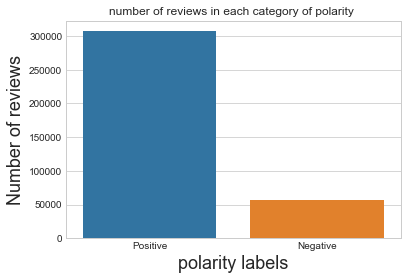

In [9]:
#getting the number of revies presernt in each category

polarity_count = amazon_data_final["Score"].value_counts()
print(polarity_count)

#ploting the number of reviews in each category
sns.set_style('whitegrid')
sns.barplot(polarity_count.index , polarity_count.values)
plt.title("number of reviews in each category of polarity ")
plt.ylabel('Number of reviews', fontsize=18)
plt.xlabel('polarity labels', fontsize=18) 





### Observation:
1) Clearly we san see that dataset is imbalanced , with positive class in majority

# Text Pre-Processing

In [10]:
#importing required libraries
import re

#pre-defined finctions to remove html tags ,punctuations, special characters

#function fro removing html tags
def remove_html (sentence):
    cleanhtml = re.compile('<.*?>')
    clean_text = re.sub(cleanhtml,' ',str(sentence))
    return clean_text

#function for removing punctuations and special characters
def remove_punc(sentence):
    cleanpunc = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleanpunc = re.sub(r'[.|,|)|(|\|/]',r' ',cleanpunc)
    cleanpunc = cleanpunc.strip()
    cleanpunc = cleanpunc.replace("\n" ,'')
    return cleanpunc
    
    
#function for keeping only alphabets
def keep_alpha(sentence):
    alpha_sentence = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sentence += alpha_word
        alpha_sentence += " "
    alpha_sentence = alpha_sentence.strip()
    return alpha_sentence





In [11]:
#removing stopwords with some exceptions and do stemmming
#initializing stopwords with some exceptions words like not and very and stemming 
import nltk
#nltk.download("stopwords")

from nltk.corpus import stopwords

exceptions = set(("very","not","few","against","more" ,"between",))

stop_words = set(stopwords.words('english')) - exceptions
stop_words.update(['zero','one','two','three','four','five','six','seven','eight',
                   'nine','ten','may','also','however','yet'])
print(stop_words)

#function for removing stopwords

def remove_stopwords(sentence):
    no_stopword_review = ""
    for word in sentence.split():
        if word not in stop_words:
            no_stopword_review += word
            no_stopword_review += " "
    no_stopword_review = no_stopword_review.strip()
    return no_stopword_review


#stemming
sno = nltk.stem.SnowballStemmer('english')

#function to do stemming
def stem_remove(sentence):
    stem_sentence = ""
    for word in sentence.split():
        stem_word = sno.stem(word)
        stem_sentence += stem_word
        stem_sentence += " "
    stem_sentence = stem_sentence.strip()
    return stem_sentence




{'shan', 'through', 'out', 'don', 've', 'just', 'why', 'it', 'them', 'they', 'won', "that'll", 'into', "couldn't", 'doesn', 'itself', 'before', 'there', 'five', 'because', 'is', 'being', "you've", 'after', 'below', 'hasn', 'she', 't', 'some', "weren't", 'are', 'whom', "hadn't", "isn't", 'until', 'yet', 'now', "you'll", 'those', 'our', 'hers', 'no', 'both', 'above', 'myself', 'when', 'haven', "haven't", 'her', 'had', 'didn', 'your', 'an', "shouldn't", 'or', 'how', 'what', 'up', 'own', 'yours', 'once', 'll', 'wasn', 'me', 'ourselves', 'who', "it's", 'can', 'him', 'his', 'further', 'on', "wasn't", 'himself', 'needn', 'should', "needn't", 'eight', 'a', 'of', 'such', 'again', 'their', 'my', 'three', 'same', 'so', 'he', 'that', 'at', 'couldn', 'isn', 'here', 'these', 'most', 'shouldn', 'will', 'one', 'nor', "should've", 'hadn', 'i', 'than', 'did', 'wouldn', 'with', 'ours', 're', 'two', 'does', 'been', 'weren', 'only', 'we', 'off', 'm', 'from', 'then', 'be', 'theirs', 'd', "you're", 'however'

In [12]:
#applying all pre-processing functions on the text to get cleaned text
amazon_data_final['Text'] = amazon_data_final["Text"].str.lower()
amazon_data_final['Text'] = amazon_data_final['Text'].apply(remove_html)
amazon_data_final["Text"] = amazon_data_final["Text"].apply(remove_punc)
amazon_data_final["Text"] = amazon_data_final["Text"].apply(keep_alpha)
amazon_data_final["Text"] = amazon_data_final["Text"].apply(remove_stopwords)
amazon_data_final["Text"] = amazon_data_final["Text"].apply(stem_remove)


In [13]:
#reseting the index
amazon_data_final.reset_index(drop= True ,inplace =True)

In [14]:
#saving the data after pre-processing
amazon_data_final.to_csv("Reviews_final.csv", index =False)